# 🎨 SOFAI-Core: Graph Coloring Domain

## Graph Coloring Decision Problem

In this notebook, you will learn:

1. **What is Graph Coloring?** - The decision problem and its applications
2. **The DIMACS Format** - How graphs are represented
3. **Domain Architecture** - How the Graph Coloring domain is structured
4. **Each Component in Detail** - Generator, Validator, Prompt Builder, Parser
5. **Running the Full Pipeline** - End-to-end solve with SOFAI

---

### 📚 Prerequisites

Before starting, make sure you have:
- Completed the first notebook: `sofai_lab_creating_domains.ipynb`
- Python 3.10+ with requirements installed
- Ollama with a model (for live demos)
- Basic understanding of graph theory

---

## Part 1: Understanding the Graph Coloring Problem

### What is Graph Coloring?

**Graph Coloring** is a classic Constraint Satisfaction Problem (CSP) where:
- You have a graph with **vertices** (nodes) and **edges** (connections)
- You must assign a **color** to each vertex
- **Constraint**: No two adjacent vertices (connected by an edge) can have the same color

### The Decision Problem

The **Graph Coloring Decision Problem** asks:
> Given a graph G and k colors, is it possible to color G with at most k colors?

This is NP-complete for k ≥ 3!

### Chromatic Number

The **chromatic number** χ(G) is the minimum number of colors needed to color graph G.

```
Example: Triangle (3 nodes, all connected)

    A ─── B          A(🔴) ─── B(🔵)
     \   /            \       /
      \ /              \     /
       C                C(🟢)

χ(Triangle) = 3 (need 3 colors)
```

### Real-World Applications

| Application | Vertices | Edges | Colors |
|-------------|----------|-------|--------|
| Exam Scheduling | Exams | Student conflicts | Time slots |
| Register Allocation | Variables | Interference | CPU registers |
| Map Coloring | Regions | Borders | Colors |
| Frequency Assignment | Transmitters | Interference | Frequencies |

In [1]:
# Clone repo
!git clone https://github.com/SOFAI-LM-AAAILab/SOFAI-LM.git
%cd SOFAI-LM

Cloning into 'SOFAI-LM'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 82 (delta 18), reused 72 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (82/82), 748.74 KiB | 24.96 MiB/s, done.
Resolving deltas: 100% (18/18), done.
/content/SOFAI-LM


In [2]:
# Setup: Add project root to path
import sys
import os

project_root = os.path.dirname(os.getcwd()) if 'notebooks' in os.getcwd() else os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")

Project root: /content/SOFAI-LM


---

## Part 2: Graph Representation - DIMACS Format

SOFAI uses the **DIMACS** format for graph files (`.col` extension).

### DIMACS Format Structure

```
c This is a comment line
p edge <num_vertices> <num_edges>
e <vertex1> <vertex2>
e <vertex1> <vertex2>
...
```

### Example

```
p edge 4 5
e a b
e a c
e b c
e b d
e c d
```

This represents:
```
    a ─── b
    |\   /|
    | \ / |
    |  X  |
    | / \ |
    |/   \|
    c ─── d
```

In [3]:
# Let's look at how SOFAI parses DIMACS files
from domains.graph_coloring.utils import parse_graph

# First, let's create a sample DIMACS file
sample_dimacs = """
p edge 4 5
e a b
e a c
e b c
e b d
e c d
"""

# Save it temporarily
os.makedirs('temp', exist_ok=True)
with open('temp/sample_graph.col', 'w') as f:
    f.write(sample_dimacs)

# Parse it
graph_repr, num_edges, num_vertices, edges, vertices = parse_graph('temp/sample_graph.col')

print("📊 Parsed Graph Information:")
print("=" * 40)
print(f"Number of vertices: {num_vertices}")
print(f"Number of edges: {num_edges}")
print(f"Vertices: {vertices}")
print(f"Edges: {edges}")
print("\n📝 Graph Representation (for prompts):")
print(graph_repr)

📊 Parsed Graph Information:
Number of vertices: 4
Number of edges: 5
Vertices: ['c', 'b', 'd', 'a']
Edges: ['a b', 'a c', 'b c', 'b d', 'c d']

📝 Graph Representation (for prompts):
p edge 4 5
e a b
e a c
e b c
e b d
e c d


---

## Part 3: The Graph Coloring Domain Architecture

The Graph Coloring domain is organized into several modules:

```
domains/graph_coloring/
├── graph_coloring_domain.py    # Main DomainInterface implementation
├── generator.py                # Graph generation (Erdős–Rényi)
├── validator.py                # Solution validation
├── prompt_builder.py           # LLM prompt construction
├── solution_parser.py          # Parse LLM responses
├── utils.py                    # DIMACS parsing utilities
├── s2_solver.py                # Legacy DSATUR solver (not used)
└── problems/                   # Generated problem files
```

### Data Flow

```
┌──────────────────────────────────────────────────────────────────┐
│                                                                  │
│  1. GENERATOR        2. DOMAIN          3. MCModule              │
│  ─────────────       ─────────          ────────────             │
│  Creates random  →   Wraps as     →     Orchestrates             │
│  Erdős–Rényi         Problem            S1/S2 solving            │
│  graph (DIMACS)      object                                      │
│                                                                  │
│       ↓                                      ↓                   │
│                                                                  │
│  4. PROMPT_BUILDER   5. LLM           6. SOLUTION_PARSER         │
│  ─────────────────   ─────           ─────────────────           │
│  Creates prompt  →   Generates   →   Extracts (vertex color)    │
│  with graph          response        pairs from text             │
│  description                                                     │
│                                                                  │
│       ↓                                      ↓                   │
│                                                                  │
│  7. VALIDATOR                                                    │
│  ─────────────                                                   │
│  Checks that no adjacent vertices have same color                │
│  Returns: (is_valid, list_of_violations)                         │
│                                                                  │
└──────────────────────────────────────────────────────────────────┘
```

In [4]:
# Let's import and explore the main domain class
from domains.graph_coloring.graph_coloring_domain import GraphColoringDomain, GraphColoringProblem

# Create domain instance
domain = GraphColoringDomain()

print("🎨 GraphColoringDomain")
print("=" * 50)
print("\nThis domain implements DomainInterface for graph coloring.")
print("\nKey components:")
print("  • GraphColoringProblem - Container for problem data")
print("  • GraphColoringGenerator - Creates random graphs")
print("  • GraphColoringValidator - Checks solutions")

🎨 GraphColoringDomain

This domain implements DomainInterface for graph coloring.

Key components:
  • GraphColoringProblem - Container for problem data
  • GraphColoringGenerator - Creates random graphs
  • GraphColoringValidator - Checks solutions


---

## Part 4: Component Deep Dives

Let's examine each component in detail.

### 4.1 The Problem Container

In [5]:
# The GraphColoringProblem class holds all problem data
print("📦 GraphColoringProblem")
print("=" * 50)
print("""
class GraphColoringProblem:
    def __init__(self, file_path: str, min_colors: int):
        self.file_path = file_path      # Path to DIMACS .col file
        self.min_colors = min_colors    # Chromatic number (minimum colors needed)

        # Parsed from file:
        self.graph_repr = ...           # String representation for prompts
        self.num_edges = ...            # Number of edges
        self.num_vertices = ...         # Number of vertices
        self.edges = [...]              # List of "v1 v2" strings
        self.vertices = [...]           # List of vertex labels
""")

# Create a problem from our sample file
problem = GraphColoringProblem('temp/sample_graph.col', min_colors=3)

print("\nExample problem:")
print(f"  File: {problem.file_path}")
print(f"  Chromatic number: {problem.min_colors}")
print(f"  Vertices: {problem.vertices}")
print(f"  Edges: {problem.edges}")

📦 GraphColoringProblem

class GraphColoringProblem:
    def __init__(self, file_path: str, min_colors: int):
        self.file_path = file_path      # Path to DIMACS .col file
        self.min_colors = min_colors    # Chromatic number (minimum colors needed)
        
        # Parsed from file:
        self.graph_repr = ...           # String representation for prompts
        self.num_edges = ...            # Number of edges
        self.num_vertices = ...         # Number of vertices
        self.edges = [...]              # List of "v1 v2" strings
        self.vertices = [...]           # List of vertex labels


Example problem:
  File: temp/sample_graph.col
  Chromatic number: 3
  Vertices: ['c', 'b', 'd', 'a']
  Edges: ['a b', 'a c', 'b c', 'b d', 'c d']


### 4.2 The Graph Generator

In [6]:
from domains.graph_coloring.generator import GraphColoringGenerator
import networkx as nx

print("🔧 GraphColoringGenerator")
print("=" * 50)
print("""
Uses the Erdős–Rényi model G(n, p):
  - n = number of vertices
  - p = probability of edge between any two vertices

Higher p → More edges → Higher chromatic number
""")

generator = GraphColoringGenerator(output_dir='temp/problems')

# Generate graphs with different edge probabilities
print("\n📊 Effect of edge probability on chromatic number:")
print("-" * 50)

for p in [0.2, 0.4, 0.6, 0.8]:
    G = generator.generate_graph(n_vertices=10, p=p)
    chi = generator.chromatic_number(G)
    edges = len(G.edges())
    print(f"p={p:.1f}: {edges:2d} edges, χ(G)={chi} colors needed")

🔧 GraphColoringGenerator

Uses the Erdős–Rényi model G(n, p):
  - n = number of vertices
  - p = probability of edge between any two vertices
  
Higher p → More edges → Higher chromatic number


📊 Effect of edge probability on chromatic number:
--------------------------------------------------
p=0.2:  9 edges, χ(G)=3 colors needed
p=0.4: 25 edges, χ(G)=5 colors needed
p=0.6: 29 edges, χ(G)=4 colors needed
p=0.8: 33 edges, χ(G)=6 colors needed


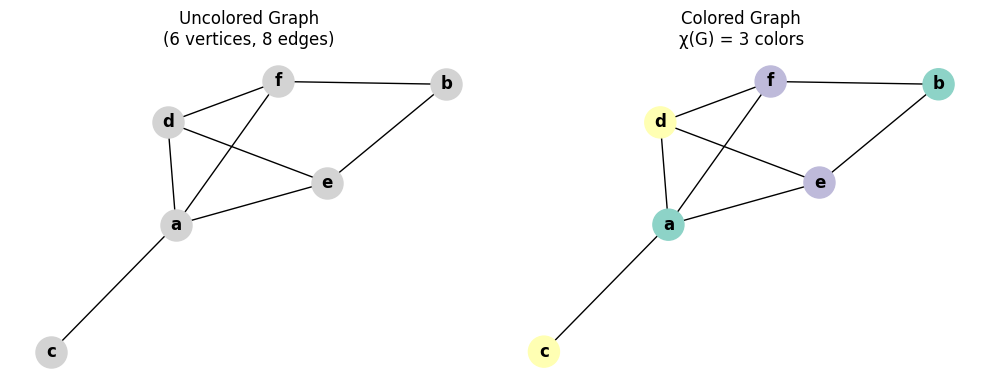


🎨 Coloring assignment:
  a: Color 1
  b: Color 1
  c: Color 2
  d: Color 2
  e: Color 3
  f: Color 3


In [7]:
# Visualize a generated graph
import matplotlib.pyplot as plt

# Generate a small graph for visualization
G = generator.generate_graph(n_vertices=6, p=0.5)

plt.figure(figsize=(10, 4))

# Subplot 1: Uncolored graph
plt.subplot(1, 2, 1)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightgray',
        node_size=500, font_size=12, font_weight='bold')
plt.title(f"Uncolored Graph\n({len(G.nodes())} vertices, {len(G.edges())} edges)")

# Subplot 2: Colored graph
plt.subplot(1, 2, 2)
coloring = nx.coloring.greedy_color(G, strategy='largest_first')
colors = [coloring[node] for node in G.nodes()]
color_map = plt.cm.Set3(range(max(colors) + 1))
node_colors = [color_map[c] for c in colors]
nx.draw(G, pos, with_labels=True, node_color=node_colors,
        node_size=500, font_size=12, font_weight='bold')
plt.title(f"Colored Graph\nχ(G) = {max(colors) + 1} colors")

plt.tight_layout()
plt.show()

print("\n🎨 Coloring assignment:")
for node, color in sorted(coloring.items()):
    print(f"  {node}: Color {color + 1}")

### 4.3 The Validator

In [8]:
from domains.graph_coloring.validator import GraphColoringValidator

print("✅ GraphColoringValidator")
print("=" * 50)
print("""
Checks that no two adjacent vertices have the same color.

Returns:
  - (True, []) if valid
  - (False, [(u,v), ...]) if invalid (list of violating edges)
""")

# Use our sample graph
validator = GraphColoringValidator('temp/sample_graph.col')

# Test a VALID coloring
valid_coloring = {'a': 1, 'b': 2, 'c': 3, 'd': 1}
is_valid, errors = validator.validate_coloring(valid_coloring)
print(f"\n✓ Testing valid coloring: {valid_coloring}")
print(f"  Result: is_valid={is_valid}, errors={errors}")

# Test an INVALID coloring (a and c same color, but connected)
invalid_coloring = {'a': 1, 'b': 2, 'c': 1, 'd': 2}
is_valid, errors = validator.validate_coloring(invalid_coloring)
print(f"\n✗ Testing invalid coloring: {invalid_coloring}")
print(f"  Result: is_valid={is_valid}")
print(f"  Violations: {errors}")
print(f"  (a and c are connected but both have color 1)")

✅ GraphColoringValidator

Checks that no two adjacent vertices have the same color.

Returns:
  - (True, []) if valid
  - (False, [(u,v), ...]) if invalid (list of violating edges)


✓ Testing valid coloring: {'a': 1, 'b': 2, 'c': 3, 'd': 1}
  Result: is_valid=True, errors=[]

✗ Testing invalid coloring: {'a': 1, 'b': 2, 'c': 1, 'd': 2}
  Result: is_valid=False
  Violations: [('a', 'c'), ('b', 'd')]
  (a and c are connected but both have color 1)


### 4.4 The Prompt Builder

In [9]:
from domains.graph_coloring.prompt_builder import prompt_generator

print("📝 Prompt Builder")
print("=" * 50)
print("""
Creates a prompt for the LLM that includes:
  - Problem description
  - Graph representation (edges)
  - Number of colors available
  - Expected output format
  - Optional: Episodic examples (few-shot learning)
""")

# Generate a prompt for our sample graph
prompt = prompt_generator(
    graph_content=graph_repr,
    min_colors=3,
    additional_examples=None
)

print("\n📜 Generated Prompt:")
print("=" * 50)
print(prompt)

📝 Prompt Builder

Creates a prompt for the LLM that includes:
  - Problem description
  - Graph representation (edges)
  - Number of colors available
  - Expected output format
  - Optional: Episodic examples (few-shot learning)


📜 Generated Prompt:

    Problem Description:
    You are given an undirected graph with 3 colors available. Your task is to assign a color to each vertex such that no two adjacent vertices share the same color.

    Graph Representation:
    - Number of vertices and edges: `p edge <number_of_vertices> <number_of_edges>`.
    - Edges between vertices are listed as follows:
    p edge 4 5
e a b
e a c
e b c
e b d
e c d

    Objective:
    Assign a unique color to each vertex, ensuring that no two vertices connected by an edge have the same color. Use no more than 3 distinct colors. Provide the color assignments for each vertex in the format:
    (Vertex Color)
    
    Example Format:
    (a 1)
    (b 2)
    (c 1)

    Please provide the color assignment direct

In [10]:
# Prompt with episodic examples (few-shot learning)
print("📜 Prompt WITH Episodic Examples (Few-Shot):")
print("=" * 50)

# Simulate past problem-solution pairs from memory
episodic_examples = [
    ("p edge 3 3\ne x y\ne y z\ne z x", "(x 1)\n(y 2)\n(z 3)"),
]

prompt_few_shot = prompt_generator(
    graph_content=graph_repr,
    min_colors=3,
    additional_examples=episodic_examples
)

print(prompt_few_shot)

📜 Prompt WITH Episodic Examples (Few-Shot):

    Problem Description:
    You are given an undirected graph with 3 colors available. Your task is to assign a color to each vertex such that no two adjacent vertices share the same color.

    Graph Representation:
    - Number of vertices and edges: `p edge <number_of_vertices> <number_of_edges>`.
    - Edges between vertices are listed as follows:
    p edge 4 5
e a b
e a c
e b c
e b d
e c d

    Objective:
    Assign a unique color to each vertex, ensuring that no two vertices connected by an edge have the same color. Use no more than 3 distinct colors. Provide the color assignments for each vertex in the format:
    (Vertex Color)
    
    Example Format:
    (a 1)
    (b 2)
    (c 1)

    
Previous Examples:
('p edge 3 3\ne x y\ne y z\ne z x', '(x 1)\n(y 2)\n(z 3)')
Please provide the color assignment directly below:
    


### 4.5 The Solution Parser

In [11]:
from domains.graph_coloring.solution_parser import parse_solution

print("🔍 Solution Parser")
print("=" * 50)
print("""
Extracts (vertex color) pairs from LLM responses.

Expected format: (vertex color)
Example: (a 1), (b 2), (c 3)

Uses regex: r"\\((\\w+)\\s+(\\d+)\\)"
""")

# Test various LLM response formats
test_responses = [
    # Clean format
    """(a 1)
(b 2)
(c 3)
(d 1)""",

    # With extra text
    """Let me solve this step by step...
The graph has 4 vertices.
(a 1)
(b 2)
(c 3)
(d 1)
This uses 3 colors which is optimal.""",

    # Alternative formatting (won't parse)
    """a: color 1
b: color 2"""
]

for i, response in enumerate(test_responses, 1):
    parsed = parse_solution(response)
    print(f"\nResponse {i}:")
    print(f"  Input (first 50 chars): {response[:50]}...")
    print(f"  Parsed: {parsed}")

🔍 Solution Parser

Extracts (vertex color) pairs from LLM responses.

Expected format: (vertex color)
Example: (a 1), (b 2), (c 3)

Uses regex: r"\((\w+)\s+(\d+)\)"


Response 1:
  Input (first 50 chars): (a 1)
(b 2)
(c 3)
(d 1)...
  Parsed: {'a': 1, 'b': 2, 'c': 3, 'd': 1}

Response 2:
  Input (first 50 chars): Let me solve this step by step...
The graph has 4 ...
  Parsed: {'a': 1, 'b': 2, 'c': 3, 'd': 1}

Response 3:
  Input (first 50 chars): a: color 1
b: color 2...
  Parsed: {}


---

## Part 5: The Complete Domain Implementation

Now let's see how all the pieces fit together in `GraphColoringDomain`.

In [12]:
# Full domain workflow demonstration
print("🎮 Complete Domain Workflow")
print("=" * 60)

# Step 1: Create domain
domain = GraphColoringDomain()
print("\n1️⃣ Created GraphColoringDomain")

# Step 2: Generate a problem
problem = domain.generate_problem(num_nodes=5, edge_prob=0.6)
print(f"\n2️⃣ Generated Problem:")
print(f"   File: {problem.file_path}")
print(f"   Vertices: {problem.num_vertices}")
print(f"   Edges: {problem.num_edges}")
print(f"   Chromatic number: {problem.min_colors}")

# Step 3: Build prompt
prompt = domain.build_prompt(problem)
print(f"\n3️⃣ Built Prompt ({len(prompt)} chars)")
print(f"   Preview: {prompt[:100]}...")

# Step 4: Simulate LLM response
simulated_response = "\n".join([f"({v} {i % problem.min_colors + 1})" for i, v in enumerate(problem.vertices)])
print(f"\n4️⃣ Simulated LLM Response:")
print(f"   {simulated_response}")

# Step 5: Parse solution
solution = domain.parse_solution(simulated_response)
print(f"\n5️⃣ Parsed Solution:")
print(f"   {solution}")

# Step 6: Validate
is_valid, errors = domain.validate_solution(problem, solution)
print(f"\n6️⃣ Validation Result:")
print(f"   Valid: {is_valid}")
if not is_valid:
    feedback = domain.format_feedback(errors)
    print(f"   Feedback: {feedback}")

# Step 7: Memory representation
prob_repr = domain.get_problem_representation(problem)
sol_repr = domain.format_solution_for_memory(solution)
print(f"\n7️⃣ Memory Representations:")
print(f"   Problem: {prob_repr[:50]}...")
print(f"   Solution: {sol_repr[:50]}...")

🎮 Complete Domain Workflow

1️⃣ Created GraphColoringDomain

2️⃣ Generated Problem:
   File: domains/graph_coloring/problems/graph_n5_graph0.col
   Vertices: 5
   Edges: 7
   Chromatic number: 3

3️⃣ Built Prompt (775 chars)
   Preview: 
    Problem Description:
    You are given an undirected graph with 3 colors available. Your task i...

4️⃣ Simulated LLM Response:
   (c 1)
(a 2)
(e 3)
(d 1)
(b 2)

5️⃣ Parsed Solution:
   {'c': 1, 'a': 2, 'e': 3, 'd': 1, 'b': 2}

6️⃣ Validation Result:
   Valid: False
   Feedback: adjacent vertices a and b have the same color

7️⃣ Memory Representations:
   Problem: p edge 5 7
e a b
e a c
e a d
e a e
e b e
e c e
e d...
   Solution: (c 1)
(a 2)
(e 3)
(d 1)
(b 2)...


---

## Part 6: Running with the Full SOFAI Framework 🚀

Now let's run the complete pipeline with the MCModule.

**Note**: This requires Ollama to be running.

In [13]:
# system deps
!sudo apt-get update
!sudo apt-get install -y zstd

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,302 kB]
Get:5 https://cli.github.com/packages stable/main amd64 Packages [354 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,637 kB]
Hit:13 https://ppa.launchpadconten

In [14]:
# Install Ollama
!curl https://ollama.ai/install.sh | sh
!pip install -q ollama

!nvidia-smi
!ollama serve > /tmp/ollama.log 2>&1 &
!sleep 2


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13862    0 13862    0     0  42207      0 --:--:-- --:--:-- --:--:-- 42262
>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tar.zst
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
Sun Jan 18 19:16:06 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Per

In [16]:
# Check Ollama availability
import subprocess

def check_ollama():
    try:
        result = subprocess.run(['ollama', 'list'], capture_output=True, text=True, timeout=5)
        if result.returncode == 0:
            print("✅ Ollama is available!")
            return True
    except:
        pass
    print("❌ Ollama not available")
    return False

ollama_available = check_ollama()

✅ Ollama is available!


In [20]:
!pip install rank_bm25

In [21]:
if ollama_available:
    from core.metacognitive_module import MCModule

    print("=" * 60)
    print("🎨 Running SOFAI with Graph Coloring Domain")
    print("=" * 60)

    # Create smaller problem for demo
    domain = GraphColoringDomain()
    problem = domain.generate_problem(num_nodes=5, edge_prob=0.5)

    print(f"\n📊 Problem: {problem.num_vertices} vertices, {problem.num_edges} edges")
    print(f"   Chromatic number: {problem.min_colors}")
    print(f"\n   Graph structure:")
    print(f"   {problem.graph_repr}")

    # Create MCModule
    mc = MCModule(
        domain=domain,
        llm_model="mistral",
        max_iterations=3
    )

    # Solve!
    result = mc.solve(problem, verbose=True)

    # Display final results
    print("\n" + "=" * 60)
    print("📋 Final Results")
    print("=" * 60)
    print(f"Solved: {result['solved']}")
    print(f"Solved by: {'S1' if result['s1_solved'] else 'S2' if result['s2_solved'] else 'None'}")
    print(f"Iterations: {result['iterations']}")
    print(f"Total time: {result['total_time']:.2f}s")
    print(f"\nColoring:")
    if isinstance(result['solution'], dict):
        for v, c in sorted(result['solution'].items()):
            print(f"  {v} → Color {c}")
else:
    print("\n⚠️ Skipping live demo - Ollama not available")
    print("To run: install Ollama and pull mistral model")

🎨 Running SOFAI with Graph Coloring Domain

📊 Problem: 5 vertices, 4 edges
   Chromatic number: 2

   Graph structure:
   p edge 5 4
e a b
e a d
e a e
e c e

Starting SOFAI solve process...

--- Iteration 1/3 ---


ResponseError: model 'mistral' not found (status code: 404)

---

## Part 7: How the Feedback Loop Works

When the LLM makes a mistake, the validator identifies which edges have violations, and this feedback helps the LLM correct itself.

In [ ]:
# Simulate a feedback loop
print("🔄 Simulating the Feedback Loop")
print("=" * 60)

# Create a problem
domain = GraphColoringDomain()
problem = domain.generate_problem(num_nodes=4, edge_prob=0.7)

print(f"\nGraph: {problem.graph_repr}")
print(f"Chromatic number: {problem.min_colors}")

# Iteration 1: Bad coloring (all same color)
print("\n--- Iteration 1 ---")
bad_solution = {v: 1 for v in problem.vertices}
print(f"LLM proposes: {bad_solution}")

is_valid, errors = domain.validate_solution(problem, bad_solution)
print(f"Valid: {is_valid}")

if not is_valid:
    feedback = domain.format_feedback(errors)
    print(f"Feedback sent to LLM: '{feedback}'")

# Iteration 2: Better coloring
print("\n--- Iteration 2 ---")
# Use greedy coloring for a valid solution
import networkx as nx
from domains.graph_coloring.validator import GraphColoringValidator

validator = GraphColoringValidator(problem.file_path)
G = validator.graph
proper_coloring = {node: color + 1 for node, color in nx.coloring.greedy_color(G).items()}

print(f"LLM proposes: {proper_coloring}")

is_valid, errors = domain.validate_solution(problem, proper_coloring)
print(f"Valid: {is_valid}")
print("✓ Solution accepted!")

---

## Summary: Key Takeaways 🎯

1. **Graph Coloring is NP-complete for k ≥ 3** - LLMs provide a heuristic approach

2. **DIMACS format** - Standard way to represent graphs (`p edge n m`, `e u v`)

3. **Domain Components**:
   - `Generator`: Creates Erdős–Rényi random graphs
   - `Validator`: Checks adjacency constraints
   - `PromptBuilder`: Structures the problem for LLM
   - `SolutionParser`: Extracts `(vertex color)` pairs

4. **Feedback Loop** - Validator errors are formatted and sent back to LLM for iterative improvement

5. **Episodic Memory** - Past solved graphs help with few-shot learning

---

## Next Steps

- Explore the Code Debugging domain (`domains/code_debugging/`)
- Try creating your own domain using the SimpleMathDomain as a template
- Run experiments comparing S1-only vs S1+S2 performance

Happy coloring! 🎨